# preprocessing.ipynb
*_______________________*

In this notebook, we're going to carry out all the pre-processing work for the TCGA-GBMLGG data. This is an important part, particularly for the clinical data, and the methylome and helper functions are largely inspired by the pre-processing carried out by [Vale-Silva et al., Sci Report, 2022.](https://www.nature.com/articles/s41598-021-92799-4).

The data folder and how it was constructed is available [here](https://github.com/luisvalesilva/multisurv/tree/master/data)

# Table of contents
1. [Setup & Introduction](#p1)
2. [Clinical Data](#p2)
3. [DNAm](#p3)
4. [RNA](#p4)
5. [MRI](#p5)
6. [WSI](#p6)
7. [Cross-validation splits](#p7)

# 1. Setup & Introduction <a name="p1"></a>

In [61]:
# import needed libraries
import pandas as pd
import requests
import io
import pandas as pd
import os
import numpy as np
from collections import OrderedDict
import itertools
from typing import Tuple, Dict
import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from IPython import display
import pyvips
import torch
import torch.nn.functional as F
import cv2
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load
import torchvision
from torchvision.transforms import ToTensor
import torch
import json

# base_path = '~/TCGA/GBMLGG/'
base_path = '/data/BraTS_2023'

In [62]:
dataframe = pd.read_csv('files/clinical_data.tsv', sep='\t')
dataframe.shape

(1104, 18)

In [63]:
# take only samples with brain as primary site
dataframe = dataframe[dataframe.project_id.isin(['GBM', 'LGG'])]
dataframe.shape

(1104, 18)

In [64]:
dataframe['group'].value_counts()

group
train    886
test     218
Name: count, dtype: int64

In [65]:
dataframe.sample(10)

,Unnamed: 0,submitter_id,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event,group
296,903,TCGA-HT-8104,NaN,18748.0,No,no,No,372.0,female,white,Alive,NaN,NaN,NaN,LGG,1.019178,0,train
1007,4383,TCGA-28-1756,NaN,28649.0,No,NaN,NaN,86.0,male,white,Alive,NaN,yes,yes,GBM,0.235616,0,train
1042,4418,TCGA-32-2615,NaN,22916.0,No,NaN,NaN,NaN,male,white,Dead,485.0,yes,yes,GBM,1.328767,1,train
762,4138,TCGA-08-0344,NaN,24253.0,No,NaN,NaN,NaN,male,white,Dead,3524.0,yes,yes,GBM,9.654795,1,train
127,734,TCGA-DU-8168,NaN,20136.0,No,no,No,431.0,female,white,Alive,NaN,yes,yes,LGG,1.180822,0,test
471,1078,TCGA-TM-A84Q,NaN,11668.0,No,no,No,772.0,male,white,Alive,NaN,no,yes,LGG,2.115068,0,train
33,640,TCGA-DB-A4XD,NaN,11741.0,No,no,No,1210.0,male,white,Alive,NaN,yes,yes,LGG,3.315068,0,train
364,971,TCGA-P5-A72X,NaN,7913.0,No,no,No,403.0,male,white,Alive,NaN,NaN,yes,LGG,1.104110,0,train
265,872,TCGA-HT-7688,NaN,21844.0,No,no,No,964.0,male,white,Alive,NaN,yes,yes,LGG,2.641096,0,train
278,885,TCGA-HT-7860,NaN,22034.0,No,no,No,15.0,female,white,Alive,NaN,NaN,NaN,LGG,0.041096,0,train


In [66]:
dataframe['age_at_diagnosis'].apply(lambda x: x/365).describe()

count    1103.000000
mean       51.448461
std        15.752966
min        10.909589
25%        38.580822
50%        52.463014
75%        63.243836
max        89.347945
Name: age_at_diagnosis, dtype: float64

In [67]:
dataframe[dataframe["vital_status"] == "Dead"]['days_to_death'].apply(lambda x: x/365).describe()

count    616.000000
mean       1.778603
std        2.083828
min        0.008219
25%        0.582192
50%        1.186301
75%        2.015068
max       14.153425
Name: days_to_death, dtype: float64

In [68]:
dataframe[dataframe["vital_status"] == "Alive"]['days_to_last_follow_up'].apply(lambda x: x/365).describe()

count    488.000000
mean       2.190933
std        2.283600
min        0.000000
25%        0.695205
50%        1.558904
75%        2.861644
max       17.597260
Name: days_to_last_follow_up, dtype: float64

In [69]:
# helpers function
def request_file_info(data_type):
    """
    Adapted from Vale-Silva's preprocessing.
    """
    fields = [
        'file_name',
        'cases.submitter_id',
        'cases.samples.sample_type',
        'cases.project.project_id',
        'cases.project.primary_site',
        ]

    fields = ','.join(fields)

    files_endpt = 'https://api.gdc.cancer.gov/files'

    filters = {
        'op': 'and',
        'content':[
             {
        "op": "in",
        "content":{
            "field": "cases.project.primary_site",
            "value": ["Brain"]
            }
        },{
            'op': 'in',
            'content':{
                'field': 'files.experimental_strategy',
                'value': [data_type]
                }
            }  
        ]
    }

    params = {
        'filters': filters,
        'fields': fields,
        'format': 'TSV',
        'size': '200000'
        }

    response = requests.post(files_endpt, headers = {'Content-Type': 'application/json'}, json = params)

    return pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep='\t')

In [7]:
def make_patient_file_map(df, base_dir):
    """
    Adapted from Vale-Silva's preprocessing.
    """
    
    d = {}
    for _, row in df.iterrows():
        patient = row['cases.0.submitter_id']
        if os.path.exists(os.path.join(base_dir, row.id, row.file_name)):
            if patient in d:
                if not isinstance(d[patient], tuple):
                    d[patient] = (
                        d[patient],
                        os.path.join(base_dir, row.id, row.file_name))
                else:
                    d[patient] += os.path.join(base_dir, row.id, row.file_name),
            else:
                d[patient] = os.path.join(base_dir, row.id, row.file_name)

    return d

# 2. Clinical Data <a name="p2"></a>

In [8]:
%%capture
supplementary = pd.read_csv('files/supplementary_data.tsv', sep='\t')

In [9]:
mapper_clin = {
    'patient': 'submitter_id', 
    'IDH.status': 'IDH', 
    'MGMT.promoter.status': 'MGMT',
    'X1p.19q.codeletion': 'X1p19q',
    'Chr.19.20.co.gain': '19.20.gain',
    'Chr.7.gain.Chr.10.loss': '7g10l',
    'TERT.expression.status': 'TERT',
    'ATRX.status': 'ATRX',
}

In [10]:
supplementary = supplementary.drop(columns=['IDH', 'Mutations', 'TERT']).rename(columns=mapper_clin)[list(mapper_clin.values())]
supplementary = supplementary[~supplementary.duplicated(subset=['submitter_id'], keep='first')].dropna(subset='submitter_id')

In [11]:
dataframe = dataframe.merge(supplementary, how='left', on='submitter_id')
dataframe.shape

(1104, 25)

In [12]:
for col in list(mapper_clin.values()):
    print(dataframe[col].value_counts())

submitter_id
TCGA-CS-4938    1
TCGA-06-5415    1
TCGA-06-5859    1
TCGA-06-5858    1
TCGA-06-5856    1
               ..
TCGA-P5-A77X    1
TCGA-P5-A780    1
TCGA-P5-A781    1
TCGA-QH-A65R    1
TCGA-RR-A6KC    1
Name: count, Length: 1104, dtype: int64
IDH
WT        529
Mutant    453
Name: count, dtype: int64
MGMT
Methylated      607
Unmethylated    311
Name: count, dtype: int64
X1p19q
non-codel    913
codel        169
Name: count, dtype: int64
19.20.gain
No chr 19/20 gain    969
Gain chr 19/20       104
Name: count, dtype: int64
7g10l
No combined CNA             644
Gain chr 7 & loss chr 10    429
Name: count, dtype: int64
TERT
Expressed        348
Not expressed    312
Name: count, dtype: int64
ATRX
WT        601
Mutant    208
Name: count, dtype: int64


Replace abnormal values with NaNs, which will be managed later and normalize age and mutations count.

# 3. DNAm <a name="p3"></a>

In [ ]:
%%time 
DNAm_files = request_file_info(data_type='Methylation Array')
DNAm_files.shape

In [ ]:
DNAm_files = DNAm_files[DNAm_files['cases.0.project.project_id'].str.startswith('TCGA')]
DNAm_files = DNAm_files[DNAm_files['file_name'].str.endswith('level3betas.txt')]
DNAm_files = DNAm_files[DNAm_files['cases.0.samples.0.sample_type'] == 'Primary Tumor']
DNAm_files.shape

In [ ]:
print('All rows:       ', DNAm_files.shape[0])
print('Unique patients:', DNAm_files['cases.0.submitter_id'].unique().shape[0])

In [ ]:
DNAm_files = DNAm_files[~DNAm_files.duplicated(subset=['cases.0.submitter_id'], keep='first')]
DNAm_files.shape

In [ ]:
file_map = make_patient_file_map(DNAm_files, base_dir=os.path.join(base_path, 'raw_DNAm'))
file_map = {k: file_map[k] for k in file_map if k in list(dataframe['submitter_id'])}
len(file_map)

In [ ]:
DNAm_mapping = pd.DataFrame([(k, v) for k, v in file_map.items()], columns=('submitter_id', 'DNAm'))
dataframe = dataframe.merge(DNAm_mapping, how='left', on='submitter_id')

### Process DNAm
Some files contain 480K probes and others only 27k, so only the probes common to both need to be kept for processing.

In [ ]:
sample_480k = pd.read_csv(os.path.join(base_path, 'raw_DNAm', 'f366f277-4079-449d-a781-0a0492a3ae41', 'e3976274-ad65-4d85-bf5c-9c10f2502748.methylation_array.sesame.level3betas.txt'), sep='\t', index_col=0, header=None)
sample_27k = pd.read_csv(os.path.join(base_path, 'raw_DNAm', '61fdc0ee-31d6-4051-bc1c-64feaa2e4042', 'fbc63a44-89c8-411c-87c9-05fd4138647a.methylation_array.sesame.level3betas.txt'), sep='\t', index_col=0, header=None)

probe_set = [p for p in list(sample_27k.index) if p in sample_480k.index]
len(probe_set)

In [ ]:
output_path = os.path.join(base_path, 'DNAm')
input_path = os.path.join(base_path, 'raw_DNAm')

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
for idx in tqdm.tqdm(os.listdir(input_path)):
    if not os.path.exists(os.path.join(output_path, idx)):
        os.makedirs(os.path.join(output_path, idx))
        
    files = os.listdir(os.path.join(input_path, idx))
    filename = [file for file in files if 'level3betas.txt' in file][0]
    temp_df = pd.read_csv(os.path.join(input_path, idx, filename), sep='\t', index_col=0, header=None, names=['Composite Element REF', 'Beta_value'])
    temp_df = temp_df[temp_df.index.isin(probe_set)]
    temp_df.to_csv(os.path.join(output_path, idx, filename.replace('txt', 'csv')))

In [ ]:
def replace_dnam(x):
    if pd.isna(x):
        return x
    else:
        return str(x).replace('raw_DNAm', 'DNAm').replace('txt', 'csv')
    
    
dataframe['DNAm'] = dataframe['DNAm'].apply(replace_dnam)

# 4. RNASeq <a name="p4"></a>

In [ ]:
%%time

mRNA_files = request_file_info(data_type='RNA-Seq')
mRNA_files.shape

In [ ]:
mRNA_files = mRNA_files[mRNA_files['cases.0.project.project_id'].str.startswith('TCGA')]
mRNA_files = mRNA_files[mRNA_files['file_name'].str.endswith('rna_seq.augmented_star_gene_counts.tsv')]
mRNA_files = mRNA_files[mRNA_files['cases.0.samples.0.sample_type'] == 'Primary Tumor']
mRNA_files.shape

In [ ]:
print('All rows:       ', mRNA_files.shape[0])
print('Unique patients:', mRNA_files['cases.0.submitter_id'].unique().shape[0])

In [ ]:
mRNA_files = mRNA_files[~mRNA_files.duplicated(subset=['cases.0.submitter_id'], keep='first')]
mRNA_files.shape

In [ ]:
file_map = make_patient_file_map(mRNA_files, os.path.join(base_path, 'raw_RNA'))
file_map = {k: file_map[k] for k in file_map if k in list(dataframe['submitter_id'])}
len(file_map)

In [ ]:
RNA_mapping = pd.DataFrame([(k, v) for k, v in file_map.items()], columns=('submitter_id', 'RNA'))
dataframe = dataframe.merge(RNA_mapping, how='left', on='submitter_id')

## Preprocessing
In this section, we only consider genes coding for proteins, and we also remove genes with a variance of less than 0.1 on the training set. 

In [ ]:
def load_single_file_RNA(path):
    temp_df = pd.read_csv(path, sep='\t', skiprows=6, usecols=[0, 2, 8], names=['gene_id', 'gene_type', 'fpkm_uq_unstranded']).set_index('gene_id')#, 2, 3, 4, 5, 6, 7, 8])
    temp_df = temp_df[temp_df['gene_type'] == 'protein_coding']['fpkm_uq_unstranded']
    return temp_df

dataframe_train = dataframe[dataframe.group == 'train']
file_map_train = make_patient_file_map(mRNA_files, os.path.join(base_path, 'raw_RNA'))
file_map_train = {k: file_map[k] for k in file_map if k in list(dataframe_train['submitter_id'])}
len(file_map_train)

In [ ]:
rna_train_dataframe = pd.concat([load_single_file_RNA(path) for path in file_map_train.values()], axis=1)

In [ ]:
gene_description = rna_train_dataframe.T.describe()

In [ ]:
genes_to_keep = gene_description.columns[gene_description.iloc[2, :] > 0.1].values.tolist()

In [ ]:
def load_preprocessed_single_file_RNA(path, genes_to_keep=genes_to_keep):
    temp_df = load_single_file_RNA(path)
    return temp_df.loc[genes_to_keep]

Copy clean dataframes ready for use to a new directory

In [ ]:
genes_to_keep

In [ ]:
output_path = os.path.join(base_path, 'RNA')

if not os.path.exists(output_path):
    os.makedirs(output_path)

for patient, filepath in tqdm.tqdm(file_map.items()):
    idx, filename = filepath.split('/')[-2:]
    if not os.path.exists(os.path.join(output_path, idx)):
        os.makedirs(os.path.join(output_path, idx))
        
    temp_df = load_preprocessed_single_file_RNA(filepath)
    temp_df.to_csv(os.path.join(output_path, idx, filename.replace('tsv', 'csv')))

In [ ]:
def replace_rna(x):
    if pd.isna(x):
        return x
    else:
        return str(x).replace('raw_RNA', 'RNA').replace('tsv', 'csv')
    
    
dataframe['RNA'] = dataframe['RNA'].apply(replace_rna)

# 5. MRI <a name="p5"></a>
For this part, we are using the overlap with patients from the BraTS and TCGA competitions, using the mapping file available on the competition website. Since the BraTS competition contains over a thousand cases and only 165 from the TCGA, we will first of all pre-train the models on the MRIs using a contrastive technique ([SimCLR](https://arxiv.org/abs/2002.05709)) inspired by the [MONAI tutorial](https://github.com/Project-MONAI/tutorials/tree/main/self_supervised_pretraining/vit_unetr_ssl).

In [70]:
mapping_file = 'mappings/BraTS2023_2017_GLI_Mapping.xlsx'
mapping_mri = pd.read_excel(mapping_file)
mapping_mri.head()

,BraTS2023,BraTS2021,BraTS2020,BraTS2019,BraTS2018,BraTS2017,Cohort Name (if publicly available),Site No (represents the originating institution),Local ID
0,BraTS-GLI-00000-000,BraTS2021_00000,NaN,NaN,NaN,NaN,Private Collection,18,NaN
1,BraTS-GLI-00002-000,BraTS2021_00002,NaN,NaN,NaN,NaN,Private Collection,18,NaN
2,BraTS-GLI-00003-000,BraTS2021_00003,NaN,NaN,NaN,NaN,Private Collection,18,NaN
3,BraTS-GLI-00005-000,BraTS2021_00005,NaN,NaN,NaN,NaN,Private Collection,18,NaN
4,BraTS-GLI-00006-000,BraTS2021_00006,NaN,NaN,NaN,NaN,Private Collection,18,NaN


### pretrain

In [71]:
mapping_mri_pretrain = pd.merge(
    left=mapping_mri,
    right=dataframe[["submitter_id", "group"]],
    how="left",
    left_on="Local ID ",
    right_on="submitter_id"
)
mapping_mri_pretrain.rename({"BraTS2023": "MRI"}, axis="columns", inplace=True)
mapping_mri_pretrain = mapping_mri_pretrain[["MRI", "submitter_id", "group"]]

In [72]:
mapping_mri_pretrain.sample(5)

,MRI,submitter_id,group
559,BraTS-GLI-00803-000,NaN,NaN
1113,BraTS-GLI-01529-000,TCGA-HT-7602,train
1009,BraTS-GLI-01425-000,NaN,NaN
59,BraTS-GLI-00090-000,NaN,NaN
656,BraTS-GLI-01072-000,NaN,NaN


In [73]:
mapping_mri_pretrain['group'].value_counts()

group
train    126
test      39
Name: count, dtype: int64

In [74]:
mapping_mri_pretrain.to_csv("files/mri_pretrain.csv")

### fine-tune

In [75]:
mapping_mri = mapping_mri[mapping_mri['Cohort Name (if publicly available)'].str.contains('TCGA')]
mapping_mri.shape

(167, 9)

In [76]:
mapping_mri.head()

,BraTS2023,BraTS2021,BraTS2020,BraTS2019,BraTS2018,BraTS2017,Cohort Name (if publicly available),Site No (represents the originating institution),Local ID
66,BraTS-GLI-00100-000,BraTS2021_00100,BraTS20_Training_174,BraTS19_TCIA01_231_1,Brats18_TCIA01_231_1,Brats17_TCIA_231_1,TCGA-GBM,5,TCGA-02-0085
68,BraTS-GLI-00102-000,BraTS2021_00102,BraTS20_Training_177,BraTS19_TCIA01_411_1,Brats18_TCIA01_411_1,Brats17_TCIA_411_1,TCGA-GBM,5,TCGA-02-0102
70,BraTS-GLI-00104-000,BraTS2021_00104,BraTS20_Training_229,BraTS19_TCIA04_479_1,Brats18_TCIA04_479_1,Brats17_TCIA_479_1,TCGA-GBM,8,TCGA-12-1094
71,BraTS-GLI-00105-000,BraTS2021_00105,BraTS20_Training_208,BraTS19_TCIA02_222_1,Brats18_TCIA02_222_1,Brats17_TCIA_222_1,TCGA-GBM,6,TCGA-06-1802
72,BraTS-GLI-00106-000,BraTS2021_00106,BraTS20_Training_241,BraTS19_TCIA06_372_1,Brats18_TCIA06_372_1,Brats17_TCIA_372_1,TCGA-GBM,10,TCGA-19-2631


In [77]:
# file_map = {tcga_idx: os.path.join(base_path, 'MRI', brats_idx) for tcga_idx, brats_idx in zip(mapping_mri['Local ID '], mapping_mri['BraTS2021'])}
file_map = {tcga_idx: os.path.join(base_path, 'MRI', brats_idx) for tcga_idx, brats_idx in zip(mapping_mri['Local ID '], mapping_mri['BraTS2023'])}
file_map = {k: file_map[k] for k in file_map if k in list(dataframe['submitter_id'])}
len(file_map)

165

In [78]:
MRI_mapping = pd.DataFrame([(k, v) for k, v in file_map.items()], columns=('submitter_id', 'MRI'))
dataframe = dataframe.merge(MRI_mapping, how='left', on='submitter_id')

In [79]:
dataframe.head()

,Unnamed: 0,submitter_id,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,days_to_death,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event,group,MRI
0,607,TCGA-CS-4938,NaN,11509.0,No,no,No,3574.0,female,white,Alive,NaN,no,no,LGG,9.791781,0,train,NaN
1,608,TCGA-CS-4941,NaN,24578.0,No,no,No,NaN,male,white,Dead,234.0,yes,yes,LGG,0.641096,1,train,NaN
2,609,TCGA-CS-4942,NaN,16297.0,No,no,No,NaN,female,black or african american,Dead,1335.0,no,yes,LGG,3.657534,1,train,/data/BraTS_2023/MRI/BraTS-GLI-01476-000
3,610,TCGA-CS-4943,NaN,13565.0,No,no,No,NaN,male,white,Dead,1106.0,yes,no,LGG,3.030137,1,train,NaN
4,611,TCGA-CS-4944,NaN,18494.0,No,no,No,1828.0,male,white,Alive,NaN,no,yes,LGG,5.008219,0,train,/data/BraTS_2023/MRI/BraTS-GLI-01477-000


Since the segmentation masks are also supplied and to reduce the complexity of calculating the 3D convolutions, several scenarios have been devised: training on the entire volume, training on a volume centred around the tumour, using all the modalities or just FLAIR and T1wCE.

To pre-train, simply go to the root of the project and perform the following CLI:

$ python -m data.run_mri_pretraining

**NB**: Numerous hyperparameters can be modified, such as the modalities used, whether the entire volume or just the tumour is viewed, etc...

In this work, we choose to freeze the encoder and extract embeddings from tumour-centred data with Flair and T1ce modalities. To do this, you can use the python script provided.

$ python -m data.extract_brain_embeddings

# 6. WSI <a name="p6"></a>

This part is much more complex than the previous ones, and the entire processing pipeline is described below.
First of all, as the WSIs take up a lot of storage space, those of the LGG project and those of the GBM project are stored on separate disks (code to be adapted according to each case).

In [ ]:
%%time
wsi_files = request_file_info(data_type='Diagnostic Slide')
wsi_files.shape

In [ ]:
wsi_files.head()

In [ ]:
wsi_files = wsi_files[wsi_files['cases.0.project.project_id'].str.startswith('TCGA')]
wsi_files = wsi_files[wsi_files['file_name'].str.endswith('.svs')]
wsi_files = wsi_files[wsi_files['cases.0.samples.0.sample_type'] == 'Primary Tumor']
wsi_files.shape

In [ ]:
print('All rows:       ', wsi_files.shape[0])
print('Unique patients:', wsi_files['cases.0.submitter_id'].unique().shape[0])

In [ ]:
file_map_gbm = make_patient_file_map(wsi_files, '/media/hddext/medical/TCGA-GBM_WSI/')
file_map_gbm = {k: file_map_gbm[k] for k in file_map_gbm if k in list(dataframe['submitter_id'])}
len(file_map_gbm)

In [ ]:
file_map_lgg = make_patient_file_map(wsi_files, '/archive/medical/tcga_lgg/wsi/')
file_map_lgg = {k: file_map_lgg[k] for k in file_map_lgg if k in list(dataframe['submitter_id'])}
len(file_map_lgg)

In [ ]:
file_map = {**file_map_gbm, **file_map_lgg}
len(file_map)

### Create thumbnails and masks

To create lower-resolution images and the corresponding mask, which can then be used to patch in the required areas.

To create the mask, we'll use [OTSU filtering](https://www.researchgate.net/publication/202972407_Survey_over_image_thresholding_techniques_and_quantitative_performance_evaluation) and HSV conversion to filter out felt-tip marks.
To do this, simply use the command line:
```
$ python get_wsi_thumbnails.py -p PATH/TO/YOUR/DATA
```
**In this case, as the LGGs were stored elsewhere than the GBMs, This script is used twice, once on each folder.**

### Select only one slide per each patient
For many patients, there are several slides, up to 9. For the sake of simplicity here and to eliminate as much noisy data as possible (with felt-tip markers, air bubbles, etc.), the small code below plots the corresponding thumbnail for each patient with several slides. An arbitrary choice is made (see `wsi_mapping.json`), keeping the best quality, flawless, wide and heterogeneous images. 

**Be careful, The slide index starts at zero!!!**

In [ ]:
id2path = {}
for patient_id, path in file_map.items():
    if isinstance(path, tuple):
        n_slides = len(path)
        plt.figure(figsize=(12, 12))
        for i in range(n_slides):
            plt.subplot(1, n_slides, i+1)
            plt.axis('off')
            plt.title(pyvips.Image.new_from_file(path[i]).get('aperio.AppMag'))
            thumbnail_path = '/'.join(path[i].split('/')[:-1])
            thumbnail = np.array(Image.open(os.path.join(thumbnail_path, 'thumbnail.jpg')))
            plt.imshow(thumbnail)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.show()
        idx = int(input())
        id2path[patient_id] = path[idx]
    else:
        id2path[patient_id] = path

In [ ]:
import json
with open('mappings/wsi_mapping.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(id2path, f)

In [ ]:
with open('mappings/wsi_mapping.json', 'r') as f:
    wsi_mapping = json.load(f)
    
WSI_mapping = pd.DataFrame([(k, v) for k, v in wsi_mapping.items()], columns=('submitter_id', 'WSI'))
dataframe = dataframe.merge(WSI_mapping, how='left', on='submitter_id')

# Extract patches

The first step is to extract patches for each patient. For each WSI, $n$ patches of size $s \times s$ are extracted from the low-resolution tissue mask. From these $n$ patches, we choose to keep only the $k$ with the best scores. Each patch is converted to HSV and a filter is applied to retain only the cells, from which the score is deduced. The code below illustrates this strategy with a single slide and with $n=10$ and $k=5$.

**NB: In our experiments**
$n = 1000$
$s = 256$
$k = 100$

In [ ]:
## take a random slide
path = '/archive/medical/tcga_lgg/wsi/'
paths = os.listdir(path)
p = os.path.join(path, paths[1])
files = os.listdir(p)
wsi = os.path.join(path, p, [f for f in files if f.endswith('svs')][0])
slide = pyvips.Image.new_from_file(wsi)

In [ ]:
def get_masked_hsv(patch: np.ndarray):
    patch = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)
    mask = np.tile(patch[:,:,1] > 150, (3, 1, 1)).transpose(1,2,0) * np.tile(patch[:,:,2] < 150, (3, 1, 1)).transpose(1,2,0)
    return patch*mask

class PatchExtractor:
    '''
    This is slightly modified version of the true patch extractor.
    These modifications are done for visualization purposes...
    '''
    def __init__(self, num_patches, patch_size, iterations, s_min: int = 150, v_max: int = 150):
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.iterations = iterations
        self.s_min = s_min
        self.v_max = v_max
    
    def patch_to_score(self, patch: np.ndarray):
        mask = np.tile(patch[:,:,1] > self.s_min, (3, 1, 1)).transpose(1,2,0) * np.tile(patch[:,:,2] < self.v_max, (3, 1, 1)).transpose(1,2,0)
        return (mask.sum(-1)/3).sum()

    @staticmethod
    def _from_idx_to_row_col(idx, width):
        row = (idx // width)
        col = (idx % width) 
        return (row, col)
    
    
    def __call__(self, slide, mask):
        patches_buffer = {}
        idx_buffer = {}
        factor = int(slide.width / mask.shape[1])
        delta = int(self.patch_size / factor)
        mask = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float()
        kernel = torch.ones(1, 1, delta, delta)
        probabilities = F.conv2d(mask, kernel, stride=(delta, delta))
        probabilities = probabilities.squeeze()
        n_samples = torch.argwhere(probabilities).size(0) if torch.argwhere(probabilities).size(0) < self.iterations else self.iterations
        indexes = torch.multinomial(probabilities.view(-1), n_samples, replacement=False)
        for idx in indexes:
            patch, idx = self._from_idx_to_patch(slide, idx, probabilities.size(1))
            score = int(self.patch_to_score(cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)))
            patches_buffer[score] = patch
            patches_buffer = dict(sorted(patches_buffer.items(), key=lambda x: x[0], reverse=True))
            idx_buffer[score] = idx
            idx_buffer = dict(sorted(idx_buffer.items(), key=lambda x: x[0], reverse=True))
            #patches_buffer = dict(itertools.islice(patches_buffer.items(), self.num_patches))
        
        return patches_buffer, idx_buffer
    
    def _from_idx_to_patch(self, slide, idx, width):
        idx = self._from_idx_to_row_col(idx, width)
        row = idx[0] * self.patch_size
        col = idx[1] * self.patch_size
        region = slide.crop(int(col), int(row), self.patch_size, self.patch_size)
        patch = np.ndarray(buffer=region.write_to_memory(),
                                dtype=np.uint8,
                                shape=(region.height, region.width, region.bands))
        
        return cv2.cvtColor(patch, cv2.COLOR_RGBA2RGB), idx

In [ ]:
%%time
import torch.nn.functional as F
extractor = PatchExtractor(5, 512, 10, 130, 170)
patches, idx = extractor(slide, np.load('/'.join(slide.filename.split('/')[:-1] + ['mask.npy'])))

In [ ]:
validated_patches = {k: patches[k] for k in list(patches.keys())[:5]}
validated_index = {k: idx[k] for k in list(idx.keys())[:5]}
discarded_patches = {k: patches[k] for k in list(patches.keys())[5:]}
discarded_index = {k: idx[k] for k in list(idx.keys())[5:]}

In [ ]:
plt.figure(figsize=(20,12))
plt.suptitle('Selected patches', y=0.6, fontsize=20)
for i, (score, patch) in enumerate(validated_patches.items()):
    plt.subplot(2, len(validated_patches), i+1)
    plt.axis('off')
    plt.imshow(patch)
    plt.subplot(2, len(validated_patches), (i+1)+len(validated_patches))
    plt.axis('off')
    plt.title(f'Score: {score}', fontsize=16)
    plt.imshow(get_masked_hsv(patch))
plt.subplots_adjust(
                    top=0.55, 
                    wspace=0.1, 
                    hspace=0.1)
plt.show()
plt.figure(figsize=(20,12))
plt.suptitle('Discarded patches', y=0.6, fontsize=20)
for i, (score, patch) in enumerate(discarded_patches.items()):
    plt.subplot(2, len(discarded_patches), i+1)
    plt.axis('off')
    plt.imshow(patch)
    plt.subplot(2, len(discarded_patches), (i+1)+len(discarded_patches))
    plt.axis('off')
    plt.title(f'Score: {score}', fontsize=16)
    plt.imshow(get_masked_hsv(patch))
plt.subplots_adjust(
                    top=0.55, 
                    wspace=0.1, 
                    hspace=0.1)
plt.show()

In [ ]:
thumbnail = np.array(Image.open('/'.join(slide.filename.split('/')[:-1] + ['thumbnail.jpg'])))
plt.figure(figsize=(6,6))
plt.imshow(thumbnail)
plt.axis('off')
plt.scatter(np.array(list(validated_index.values()))[:, 1] * 4, np.array(list(validated_index.values()))[:, 0] * 4, color='limegreen', marker='X', s=100)
plt.scatter(np.array(list(discarded_index.values()))[:, 1] * 4, np.array(list(discarded_index.values()))[:, 0] * 4, color='red', marker='X', s=100)
plt.show()

In the figure above, the red crosses are the patches that have not been retained and the others are those that have been retained.

# Extraction job

This is where the patch extraction code resides. Note that some slides have a magnification of **x40** and others **x20**. To have the same resolution for each patient and work at iso-micron-per-pixel, patches of size $2s \times 2s$ are extracted and then downsampled before being scored for slides with **x40** magnification.

In [ ]:
class PatchExtractor:
    def __init__(self, num_patches, patch_size, iterations, s_min: int = 120, v_max: int = 150, v_min: int = 40):
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.iterations = iterations
        self.s_min = s_min
        self.v_max = v_max
        self.v_min = v_min
    
    def patch_to_score(self, patch: np.ndarray) -> int:
        mask = np.tile(patch[:,:,1] > self.s_min, (3, 1, 1)).transpose(1,2,0) * np.tile(patch[:,:,2] < self.v_max, (3, 1, 1)).transpose(1,2,0) * np.tile(patch[:,:,2] > self.v_min, (3, 1, 1)).transpose(1,2,0)
        return (mask.sum(-1)/3).sum()

    @staticmethod
    def _from_idx_to_row_col(idx: int, width: int) -> Tuple[int, int]:
        row = (idx // width)
        col = (idx % width) 
        return (row, col)
    
    
    def __call__(self, slide: pyvips.Image, mask: np.ndarray) -> Dict[int, np.ndarray]:
        patches_buffer = {}
        factor = int(slide.width / mask.shape[1])
        delta = int(self.patch_size / factor)
        if delta == 3:
            delta = 4
        mask = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float()
        kernel = torch.ones(1, 1, delta, delta)
        probabilities = F.conv2d(mask, kernel, stride=(delta, delta))
        probabilities = probabilities.squeeze()
        if torch.argwhere(probabilities).size(0) < self.num_patches:
            print(f'The mask was too small ({torch.argwhere(probabilities).size(0)}), so you could pick anywhere in the slide')
            probabilities = torch.ones_like(probabilities)
            print(f'Number of potential patches now: {torch.argwhere(probabilities).size(0)}')
        n_samples = torch.argwhere(probabilities).size(0) if torch.argwhere(probabilities).size(0) < self.iterations else self.iterations
        indexes = torch.multinomial(probabilities.view(-1), n_samples, replacement=False)
        for idx in indexes:
            patch = self._from_idx_to_patch(slide, idx, probabilities.size(1))
            if self.patch_size == 512:
                patch = cv2.resize(patch, (256, 256))
            score = self.patch_to_score(cv2.cvtColor(patch, cv2.COLOR_RGB2HSV))
            if score in list(patches_buffer.keys()):
                score += random.random()
            patches_buffer[score] = patch
            patches_buffer = dict(sorted(patches_buffer.items(), key=lambda x: x[0], reverse=True))
            patches_buffer = dict(itertools.islice(patches_buffer.items(), self.num_patches))
        
        return patches_buffer
    
    def _from_idx_to_patch(self, slide: pyvips.Image, idx: int, width: int) -> np.ndarray:
        idx = self._from_idx_to_row_col(idx, width)
        row = idx[0] * self.patch_size
        col = idx[1] * self.patch_size
        region = slide.crop(int(col), int(row), self.patch_size, self.patch_size)
        patch = np.ndarray(buffer=region.write_to_memory(),
                                dtype=np.uint8,
                                shape=(region.height, region.width, region.bands))
        
        return cv2.cvtColor(patch, cv2.COLOR_RGBA2RGB)

In [ ]:
%%time
mapping_path = 'wsi_mapping.json'
mapping = json.load(open(mapping_path, 'r'))
num_patches = 100
iterations = 1000
patch_size = 256
for patient, wsi_path in tqdm.tqdm(mapping.items()):
    folder = '/'.join(wsi_path.split('/')[:-1])
    if os.path.exists(os.path.join(folder, 'patches')) and len(os.listdir(os.path.join(folder, 'patches'))) == num_patches:
        print('Done for patient: ', patient)
        continue
    slide = pyvips.Image.new_from_file(wsi_path)
    if int(float(slide.get('aperio.AppMag'))) == 40:
        extractor = PatchExtractor(num_patches=num_patches, patch_size=patch_size*2, iterations=iterations, s_min=130, v_max=170)
    else:
        extractor = PatchExtractor(num_patches=num_patches, patch_size=patch_size, iterations=iterations, s_min=130, v_max=170)
    mask = np.load(os.path.join(folder, 'mask.npy'))
    patches = extractor(slide, mask)
    if not os.path.exists(os.path.join(folder, 'patches')):
        os.makedirs(os.path.join(folder, 'patches'))
    
    if len(patches) != 100:
        print(patient, len(patches))
    for i, (score, patch) in enumerate(patches.items()):
        patch = Image.fromarray(patch)
        patch.save(os.path.join(folder, 'patches', f'{int(i)}_{int(score)}.png'))
        

In [ ]:
# Sanity check
for patient, wsi_path in tqdm.tqdm(mapping.items()):
    folder = '/'.join(wsi_path.split('/')[:-1])
    if len(os.listdir(os.path.join(folder, 'patches'))) != 100:
        print('Abnormal number of patches')
    
    patches = os.listdir(os.path.join(folder, 'patches'))
    for patch in patches:
        patch = os.path.join(folder, 'patches', patch)
        patch = np.array(Image.open(patch))
        if patch.shape != (256, 256, 3):
            print('Abnormal patch size, expected (256, 256, 3) got {patch.shape}')

# Self-supervised contrastive training

To reduce the dimensionality of the WSIs, we already carry out a pre-training on the patches extracted, which will be used to extract for each patient k (100 in our case) embedding of size 512 or 1024. Here we use a ResNet34 that we train with the SimCLR framework.

To do this, simply go to the root of the project and run the CLI:

```
$ python -m data.run_wsi_pretraining
```

Batch size, number of gpus, learning rate and weight decay can be adjusted on the command line. <br>
Once that's done, we retrieve the pre-trained model `models/wsi_encoder.pth` and we infer all these patches for each patient, which we store in a dataframe in the format $k \times e_{dim}$

# Embeddings extraction

In [ ]:
def clean_state_dict(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'module.encoder' in key:
            new_state_dict[key[15:]] = value
        else:
            new_state_dict[key] = value
    return new_state_dict


extractor = torchvision.models.resnet34()
extractor.fc = torch.nn.Identity()
state_dict = clean_state_dict(torch.load('./models/wsi_encoder.pth'))
extractor.load_state_dict(state_dict, strict=False)
extractor.eval()
print()

In [ ]:
with open('mappings/wsi_mapping.json', 'r') as f:
    mapping = json.load(f)

In [ ]:
output_path = os.path.join(base_path, 'WSI')
if not os.path.exists(output_path):
    os.makedirs(output_path)

file_map = {}
for patient, path in tqdm.tqdm(mapping.items(), total=len(mapping)):
    idx = path.split('/')[-2]
    patches_path = os.path.join('/'.join(path.split('/')[:-1]), 'patches')
    patches = os.listdir(patches_path)
    patches = [ToTensor()(np.array(Image.open(os.path.join(patches_path, patch)))) for patch in patches]
    patches = torch.stack(patches)
    with torch.no_grad():
        embeddings = extractor(patches)
        
    temp_df = pd.DataFrame(embeddings)
    final_path = os.path.join(output_path, idx, f'{patient}.csv')
    temp_df.to_csv(final_path, index=False)
    file_map[patient] = final_path

In [ ]:
output_path = os.path.join(base_path, 'WSI')
if not os.path.exists(output_path):
    os.makedirs(output_path)

file_map = {}
i=0
extractor.eval()
for patient, path in tqdm.tqdm(mapping.items(), total=len(mapping)):
    i+=1
    idx = path.split('/')[-2]
    if not os.path.exists(os.path.join(output_path, idx)):
        os.makedirs(os.path.join(output_path, idx))
    patches_path = os.path.join('/'.join(path.split('/')[:-1]), 'patches')
    patches = os.listdir(patches_path)
    patches = [ToTensor()(np.array(Image.open(os.path.join(patches_path, patch)))) for patch in patches]
    patches = torch.stack(patches)
    with torch.no_grad():
        embeddings = extractor(patches)
    
    temp_df = pd.DataFrame(embeddings)
    final_path = os.path.join(output_path, idx, f'{patient}.csv')
    temp_df.to_csv(final_path, index=False)
    file_map[patient] = final_path

In [ ]:
WSI_mapping = pd.DataFrame([(k, v) for k, v in file_map.items()], columns=('submitter_id', 'WSI'))
dataframe.drop(columns=['WSI'], inplace=True)
dataframe = dataframe.merge(WSI_mapping, how='left', on='submitter_id')

# 7. Cross-validation splits <a name="p7"></a>
We choose to perform a StratifiedKFold with $k = 5$, the stratification is done using the `project_id` criteria.

Project id: {'GBM': 95, 'LGG': 83}
Ratio censored/non_censored: event
1    95
0    83
Name: count, dtype: int64


/tmp/ipykernel_7082/1080552726.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_brain['split'] = splits.astype(int)


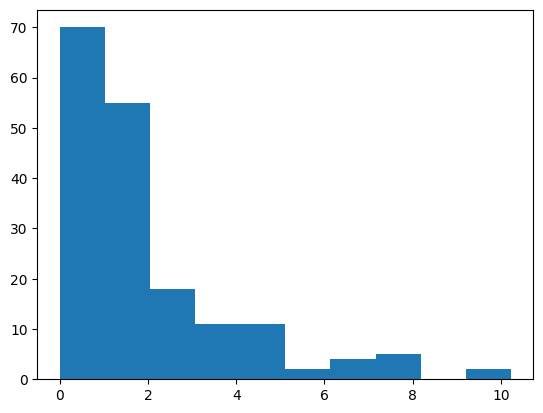

Project id: {'GBM': 95, 'LGG': 82}
Ratio censored/non_censored: event
1    102
0     75
Name: count, dtype: int64


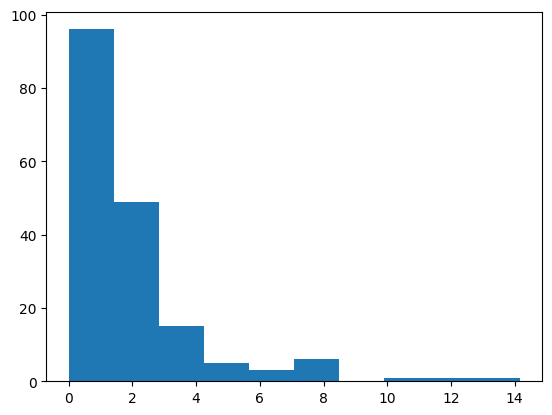

Project id: {'GBM': 95, 'LGG': 82}
Ratio censored/non_censored: event
1    91
0    86
Name: count, dtype: int64


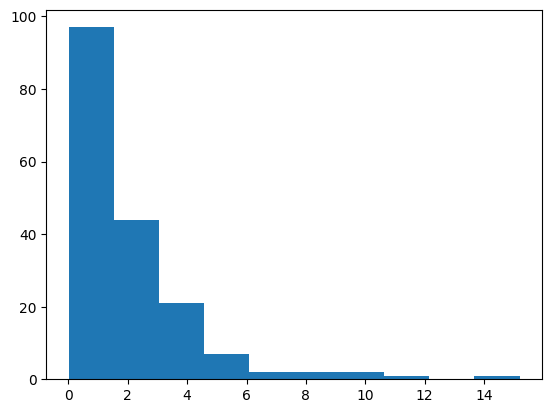

Project id: {'GBM': 95, 'LGG': 82}
Ratio censored/non_censored: event
1    102
0     75
Name: count, dtype: int64


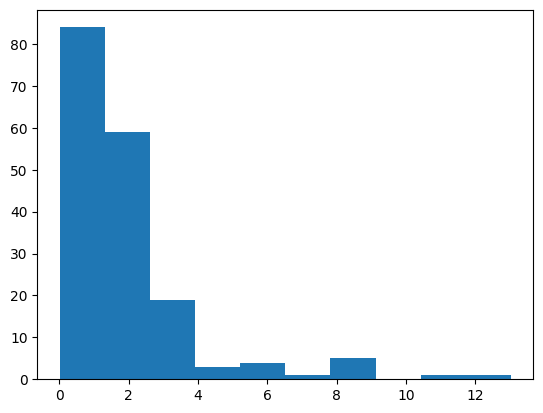

Project id: {'GBM': 95, 'LGG': 82}
Ratio censored/non_censored: event
1    102
0     75
Name: count, dtype: int64


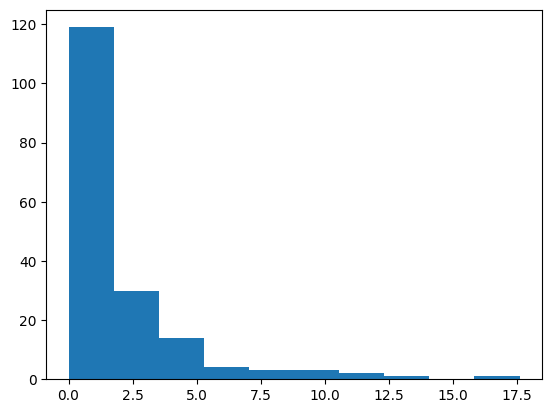

In [80]:
train_brain = dataframe[dataframe.group == 'train']
test_brain = dataframe[dataframe.group == 'test']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
splits = np.zeros(len(train_brain))
for i, (_, fold_idx) in enumerate(skf.split(train_brain, train_brain.project_id)):
    splits[fold_idx] = i


train_brain['split'] = splits.astype(int)

# sanity check
project_id = []
modalities = []
event = []
for i in range(5):
    temp_df = train_brain[train_brain.split == int(i)]
    project_id.append(dict(temp_df.project_id.value_counts()))
    event.append(dict(temp_df.event.value_counts()))
    print(f'Project id: {dict(temp_df.project_id.value_counts())}')
    print(f'Ratio censored/non_censored: {temp_df.event.value_counts()}')
    temp_modalities = {}
    for modality in ['MRI']: #['RNA', 'DNAm', 'MRI', 'WSI']:
        temp_modalities[modality] = sum(temp_df[modality].isna()) / len(temp_df)
    modalities.append(temp_modalities)
    plt.hist(temp_df.time.values)
    plt.show()

In [81]:
modalities

[{'MRI': 0.8426966292134831},
 {'MRI': 0.847457627118644},
 {'MRI': 0.8757062146892656},
 {'MRI': 0.8587570621468926},
 {'MRI': 0.864406779661017}]

## RNA Scalers

In [29]:
def log_transform(x):
    return np.log(x + 1)

for split in train_brain.split.unique():
    temp_df = train_brain[train_brain.split != int(split)]
    temp_df = pd.concat([pd.read_csv(path).set_index('gene_id') for path in temp_df.RNA if not pd.isna(path)], axis=1).T
    print(temp_df.shape)
    scaler = StandardScaler()
    log = FunctionTransformer(log_transform)
    pipe = Pipeline(steps=[('log', log) , ('scaler', scaler)])
    pipe.fit(temp_df.values)
    dump(pipe, f'rna_preprocessors/trf_{int(split)}.joblib')
    print('Done for split: ', int(split))

AttributeError: 'DataFrame' object has no attribute 'RNA'

## One last word to conclude

In [82]:
train_brain = train_brain.drop(columns=['group', 'Unnamed: 0', 'days_to_last_follow_up', 'vital_status', 'days_to_death'])
test_brain = test_brain.drop(columns=['group', 'Unnamed: 0', 'days_to_last_follow_up', 'vital_status', 'days_to_death'])
train_brain.to_csv('files/train_brain.csv', index=False)
test_brain.to_csv('files/test_brain.csv', index=False)

In [83]:
dataframe.to_csv('files/dataframe_brain.csv')